<h1 align='center'> Monte-Carlo (MCMC) </h1>

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.

1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

In [ ]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)

Empirical bound : 2.1652254894455245


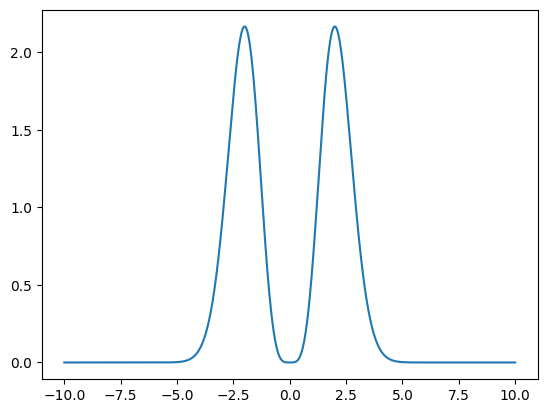

In [ ]:
M = np.max([f(x0)/g(x0) for x0 in x])
print("Empirical bound : " + str(M))

plt.plot(x, [f(x0)/g(x0) for x0 in x])
plt.show()

2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

In [ ]:
def rejection_sampling(n=1000):
    """Reject sampling algorithm for f with Gaussian proposal g."""
    N = 0
    x_acc = []
    while N < n:
      u = np.random.uniform()
      x = np.random.normal()
      if (u <= f(x) / (M * g(x))):
        x_acc.append(x)
        N += 1
    return x_acc

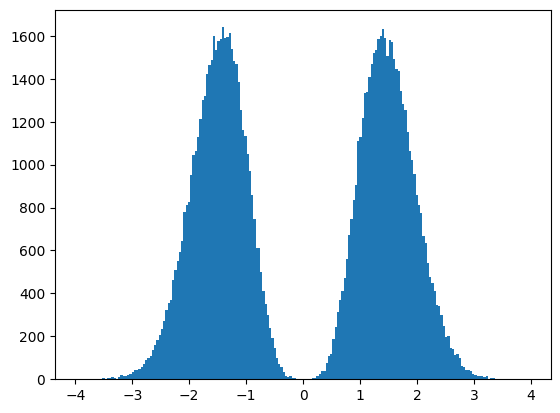

In [ ]:
plt.hist(rejection_sampling(10**(5)), bins=200)
plt.show()

In [ ]:
import scipy

normalizing_constant, error = scipy.integrate.quad(f, a = -10, b = 10)
print("Normalizing_constant  : " + str(normalizing_constant))

Normalizing_constant  : 1.3293403881791368


3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

In [ ]:
def rw_metropolis_hastings(n, f=f, seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """

    np.random.seed(seed)

    x = np.random.randn()
    x_l = []
    for i in range(0, n):
      x_l.append(x)
      y = np.random.normal() # Q(x, .) est une loi gaussienne
      r = (f(y) * g(x)) / (f(x) * g(y))
      u = np.random.uniform()
      if u < r:
        x = y
      else:
        x = x
    return x_l

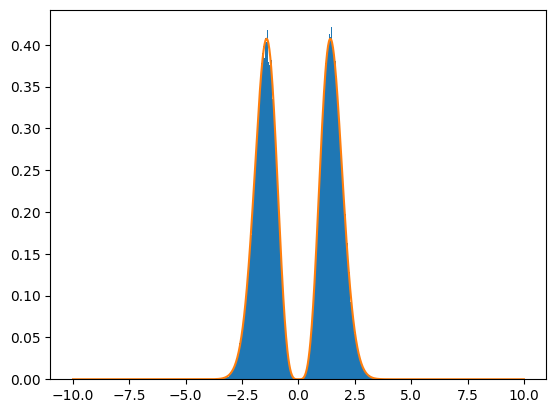

In [ ]:
rw_mh = rw_metropolis_hastings(10**(6))
plt.hist(rw_mh, bins=300, density = True)

plt.plot(x, [f(x0)/normalizing_constant for x0 in x])
plt.show()

# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

On peut écrire : $p(x_1, x_2) = \frac{1}{2\pi \sqrt{1 - \rho ^2}} \exp{(-0.5((x_1 ~ x_2) - \mu) \Gamma^{-1} ((x_1 ~ x_2) - \mu)^T)}$ avec $\mu = (0 ~ 0)$ et
$\Gamma = \begin{pmatrix} 1 &~  \rho \\
\rho &~ 1
\end{pmatrix}$

Donc ($X_1$, $X_2$) \~  $\mathcal N (\mu, \Gamma)$

On a de plus :

$\begin{align}
p(X_1 = x_1 | X_2 = x_2) &= p(x_1, x_2) / p(x_2) \\
&= A(x_2) \exp{\left(\frac{1}{2(1 - \rho^2)} ( x_1 - \rho x_2 )^2 \right)}
\end{align}$

(avec $A$ une fonction ne dépendant pas de $x_1$)

On en déduit que $X_1 | X_2 = x_2$ suit une loi $\mathcal N (\rho x_2, 1 - \rho^2)$
De même, $X_2 | X_1 = x_1$ suit une loi $\mathcal N (\rho x_1, 1 - \rho^2)$


*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [ ]:
def gibbs_sampler(n, rho):
    """Gibbs sampler for (X_1, X_2)."""
    X = []
    X1 = np.random.normal()
    X2 = np.random.normal()
    for i in range(0, n):
      X1 = np.random.normal(loc = rho * X2, scale = (1 - rho**2))
      X2 = np.random.normal(loc = rho * X1, scale = (1 - rho**2))
      X.append([X1, X2])
    return np.array(X)

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

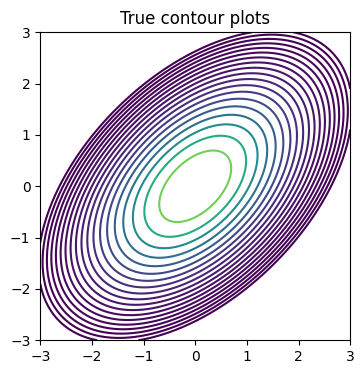

In [ ]:
from scipy.stats import multivariate_normal
rho = 0.5
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(4, 4))
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")
plt.show()

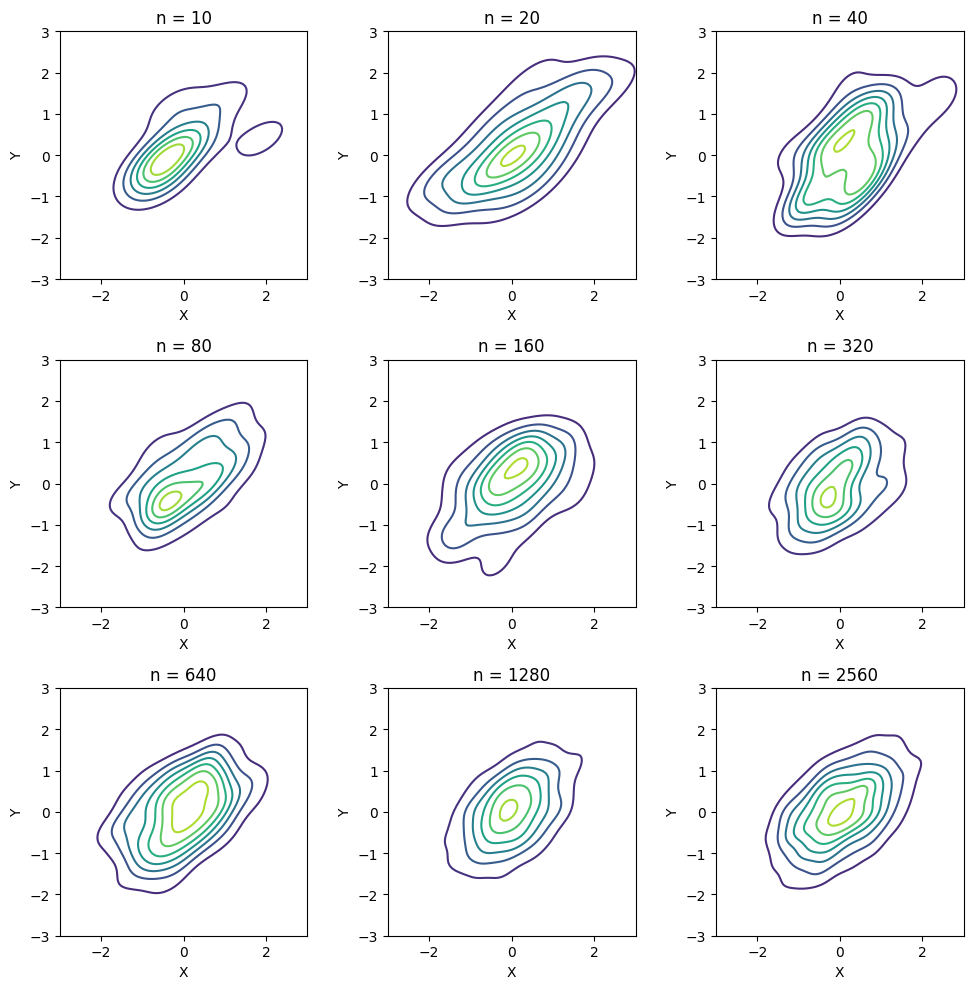

In [ ]:
# On regarde la distribution du Gibbs Sampler pour différentes valeurs de n à rho fixé
from scipy.stats import gaussian_kde

n_list = [10, 20, 40, 80, 160, 320, 640, 1280, 2 * 1280]

rho = 0.5

plt.figure(figsize=(10, 10))

for i in range(0, len(n_list)):
  X = gibbs_sampler(n_list[i], rho)
  x = X[:,0]
  y = X[:,1]

  xy = np.vstack([x, y])
  kde = gaussian_kde(xy)

  grid = np.linspace(-3, 3, 100)
  xx, yy = np.meshgrid(grid, grid)
  positions = np.vstack([xx.ravel(), yy.ravel()])
  f = np.reshape(kde(positions).T, xx.shape)

  plt.subplot(3, 3, i + 1, aspect='equal', adjustable='box')
  plt.contour(xx, yy, f)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('n = ' + str(n_list[i]))

plt.tight_layout()
plt.show()

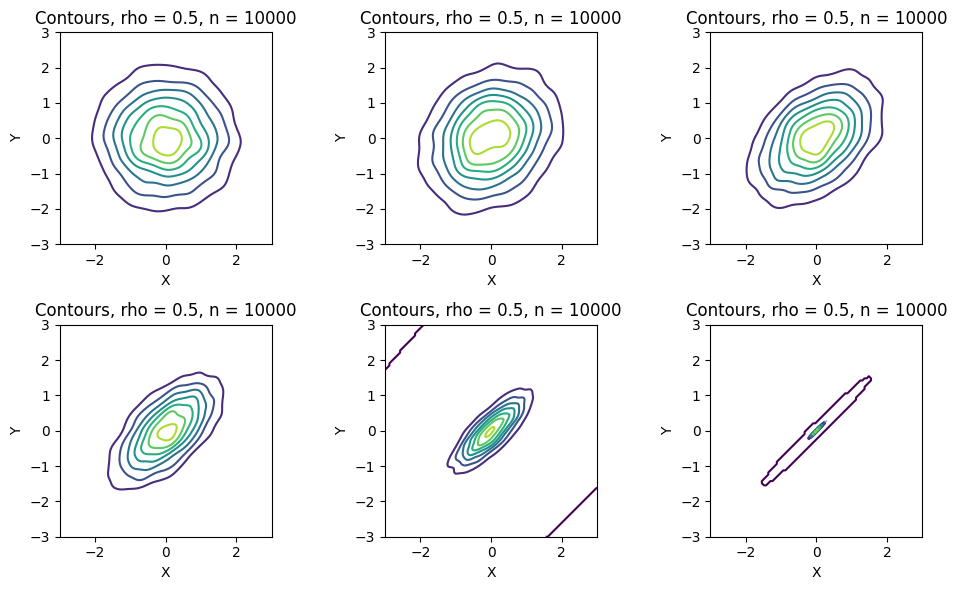

In [ ]:
# on observe l'influence de rho

plt.figure(figsize=(10, 6))

rho_list = [0, 0.2, 0.4, 0.6, 0.8, 0.99]
n = 10**(4)

for i in range(0, len(rho_list)):
  plt.subplot(2, 3, i + 1, aspect='equal', adjustable='box')

  X = gibbs_sampler(n, rho_list[i])

  x = X[:,0]
  y = X[:,1]

  xy = np.vstack([x, y])
  kde = gaussian_kde(xy)

  grid = np.linspace(-3, 3, 100)
  xx, yy = np.meshgrid(grid, grid)
  positions = np.vstack([xx.ravel(), yy.ravel()])
  f = np.reshape(kde(positions).T, xx.shape)

  plt.contour(xx, yy, f)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Contours, rho = ' + str(rho) + ', n = ' + str(n))

plt.tight_layout()
plt.show()

**Influence de $\rho$** : Lorsqu'on augmente $\rho$, on augmente la dépendance entre $x_1$ et $x_2$, ce qui se caractérise graphiquement par un alongement des contours selon l'axe (1, 1). Quand $\rho$ vaut 0, $x_1$ et $x_2$ sont décorrelés. A l'inverse, quand $\rho$ vaut 1, $x_1 = x_2$ presque surement.  

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

In [ ]:
from numpy import corrcoef

In [ ]:
rho = 0.5
X = gibbs_sampler(10**(5), rho)
X_m = [X[i//2][0] if (i%2 == 0) else X[i//2][1] for i in range(0, 2 * len(X))]

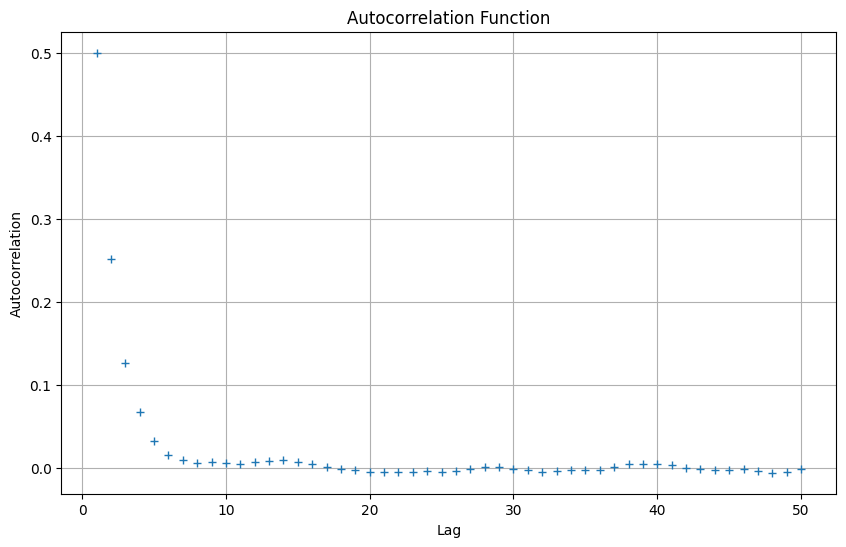

In [ ]:
max_lag = 50
lags = np.arange(1, max_lag + 1)
autocorr_values = [corrcoef(X_m[:-lag], X_m[lag:])[0, 1] for lag in lags]

plt.figure(figsize=(10, 6))
plt.plot(lags, autocorr_values, "+")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.grid(True)
plt.show()

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

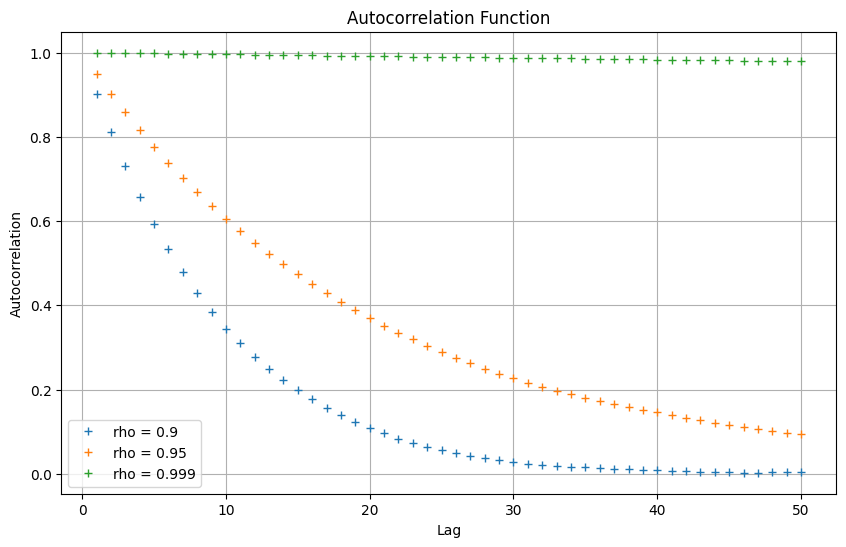

In [ ]:
X1 = gibbs_sampler(10**(5), 0.9)
X_m1 = [X1[i//2][0] if (i%2 == 0) else X1[i//2][1] for i in range(0, 2 * len(X1))]

X2 = gibbs_sampler(10**(5), 0.95)
X_m2 = [X2[i//2][0] if (i%2 == 0) else X2[i//2][1] for i in range(0, 2 * len(X2))]

X3 = gibbs_sampler(10**(5), 0.999)
X_m3 = [X3[i//2][0] if (i%2 == 0) else X3[i//2][1] for i in range(0, 2 * len(X3))]

max_lag = 50
lags = np.arange(1, max_lag + 1)
autocorr_values1 = [corrcoef(X_m1[:-lag], X_m1[lag:])[0, 1] for lag in lags]
autocorr_values2 = [corrcoef(X_m2[:-lag], X_m2[lag:])[0, 1] for lag in lags]
autocorr_values3 = [corrcoef(X_m3[:-lag], X_m3[lag:])[0, 1] for lag in lags]

plt.figure(figsize=(10, 6))
plt.plot(lags, autocorr_values1, "+", label = "rho = 0.9")
plt.plot(lags, autocorr_values2, "+", label = "rho = 0.95")
plt.plot(lags, autocorr_values3, "+", label = "rho = 0.999")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.legend()
plt.grid(True)
plt.show()


**$\rho → 1 $** : Lorsqu'on augmente $\rho$, on augmente la correlation entre $x_1$ et $x_2$, mais aussi entre $x_i$ et $x_{i+t}$ (pour tout i > 0 et t > 0). On observe graphiquement que $corr(X_i, X_{i-lag})$ tend vers 1 lorsque $\rho$ tend vers 1 (et ceci pour tout i et tout lag dans N)

**Arguments supplémentaires :** On voudrait obtenir des échantillons tels que $(X_{2i}, X_{2i+1})$ et $(X_{2i+2}, X_{2i+3})$ soient indépendants. Or on observe que quand $\rho$ est grand (proche de 1), $(X_{2i}, X_{2i+1})$ et $(X_{2i+2}, X_{2i+3})$ sont fortement corrélés (mais la correlation entre $(X_{2i}, X_{2i+1})$ et $(X_{2i+j}, X_{2i+j + 1})$ est une fonction décroissante de j). Pour éviter ce problèmes, on devrait donc pouvoir selectionner un couple de valeur $(X_i, X_{i+1})$ tout les N valeurs. On ajoute donc un argument N (entier) à la fonction, qui renvoie la liste des échantillons $(X_{Ni}, X_{Ni + 1})$ pour i allant de 1 à n.

On devrait aussi ajouter un argument "mélanger" qui vaudrait "True" ou "False". En renvoyant une liste d'échantillons tirés de la même manière mais mélangés, on réduit la corrélations entre deux échantillons successifs.

In [ ]:
def gibbs_sampler_2(n, rho, N, melange = True):
    """Gibbs sampler for (X_1, X_2)."""
    X = []
    X1 = np.random.normal()
    X2 = np.random.normal()

    for i in range(0, n*N):
      X1 = np.random.normal(loc = rho * X2, scale = (1 - rho**2))
      X2 = np.random.normal(loc = rho * X1, scale = (1 - rho**2))
      if i%N == 0:
        X.append([X1, X2])
    X = np.array(X)
    if melange:
      rng = np.random.default_rng()
      X =  rng.permutation(X, axis=1)
    return X

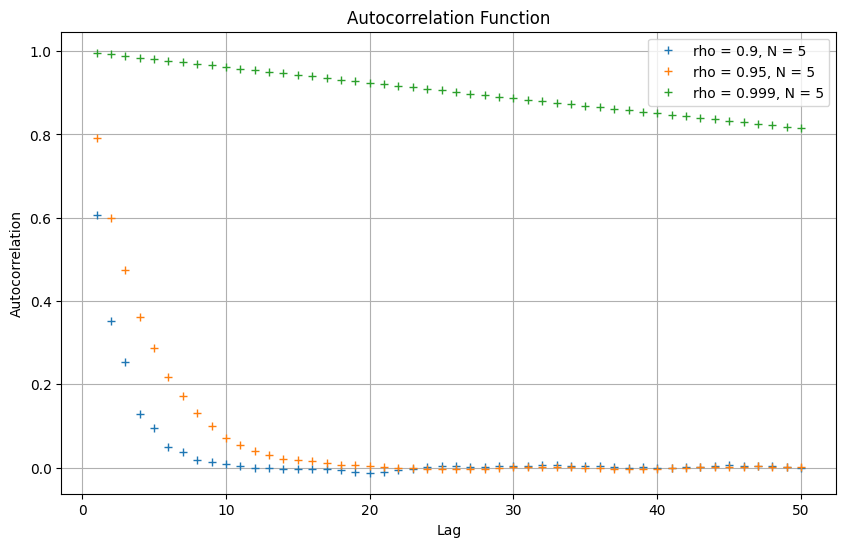

In [ ]:
X1 = gibbs_sampler_2(10**(5), 0.9, 5)
X_m1 = [X1[i//2][0] if (i%2 == 0) else X1[i//2][1] for i in range(0, 2 * len(X1))]

X2 = gibbs_sampler_2(10**(5), 0.95, 5)
X_m2 = [X2[i//2][0] if (i%2 == 0) else X2[i//2][1] for i in range(0, 2 * len(X2))]

X3 = gibbs_sampler_2(10**(5), 0.999, 5)
X_m3 = [X3[i//2][0] if (i%2 == 0) else X3[i//2][1] for i in range(0, 2 * len(X3))]

max_lag = 50
lags = np.arange(1, max_lag + 1)
autocorr_values1 = [corrcoef(X_m1[:-lag], X_m1[lag:])[0, 1] for lag in lags]
autocorr_values2 = [corrcoef(X_m2[:-lag], X_m2[lag:])[0, 1] for lag in lags]
autocorr_values3 = [corrcoef(X_m3[:-lag], X_m3[lag:])[0, 1] for lag in lags]

plt.figure(figsize=(10, 6))
plt.plot(lags, autocorr_values1, "+", label = "rho = 0.9, N = 5")
plt.plot(lags, autocorr_values2, "+", label = "rho = 0.95, N = 5")
plt.plot(lags, autocorr_values3, "+", label = "rho = 0.999, N = 5")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.legend()
plt.grid(True)
plt.show()

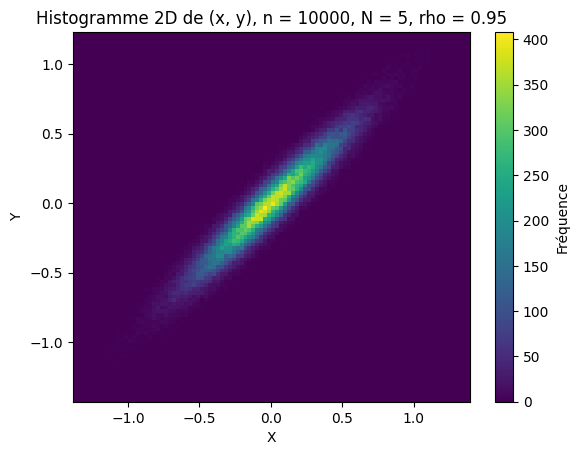

In [ ]:
plt.hist2d(X2[:, 0], X2[:, 1], bins=100)
plt.colorbar(label='Fréquence')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Histogramme 2D de (x, y), n = 10000, N = 5, rho = 0.95')
plt.show()

Les nouveaux paramètres améliorent la fonction. L'autocorrelation réduit plus vite. On ne change pas la distribution des $(X_{i}, X_{i+1})$.

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$.

In [ ]:
def rw_metropolis_hastings(n, f, tau=1., seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g."""
    def g(x):
      return multivariate_normal.pdf(x, mean=[0, 0], cov=[[tau, 0], [0, tau]])

    np.random.seed(seed)
    x = np.random.normal(size = 2)
    x_l = []

    for i in range(0, n):
      x_l.append(x)

      y = np.random.normal(0, tau, 2)
      r = (f(y) * g(x)) / (f(x) * g(y))
      u = np.random.uniform()
      if u < r:
        x = y
      else:
        x = x
    return np.array(x_l)

In [ ]:
def f(x):
  return multivariate_normal.pdf(x, [0, 0], [[1, rho], [rho, 1]])

rho = 0.5
rw_mh = rw_metropolis_hastings(2 * 10**(4), f)

In [ ]:
def contour_et_hist_plot(x, y, title):
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1, aspect='equal', adjustable='box')

  xy = np.vstack([rw_mh[:,0], rw_mh[:,1]])
  kde = gaussian_kde(xy)

  grid = np.linspace(-3, 3, 100)
  xx, yy = np.meshgrid(grid, grid)
  positions = np.vstack([xx.ravel(), yy.ravel()])
  f = np.reshape(kde(positions).T, xx.shape)

  plt.contour(xx, yy, f)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Contours, ' + title)

  plt.subplot(1, 2, 2, aspect='equal', adjustable='box')

  plt.hist2d(rw_mh[:, 0], rw_mh[:, 1], bins=100)
  plt.colorbar(label='Fréquence')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Histogramme 2D de (x, y), ' + title)

  plt.tight_layout()
  plt.show()

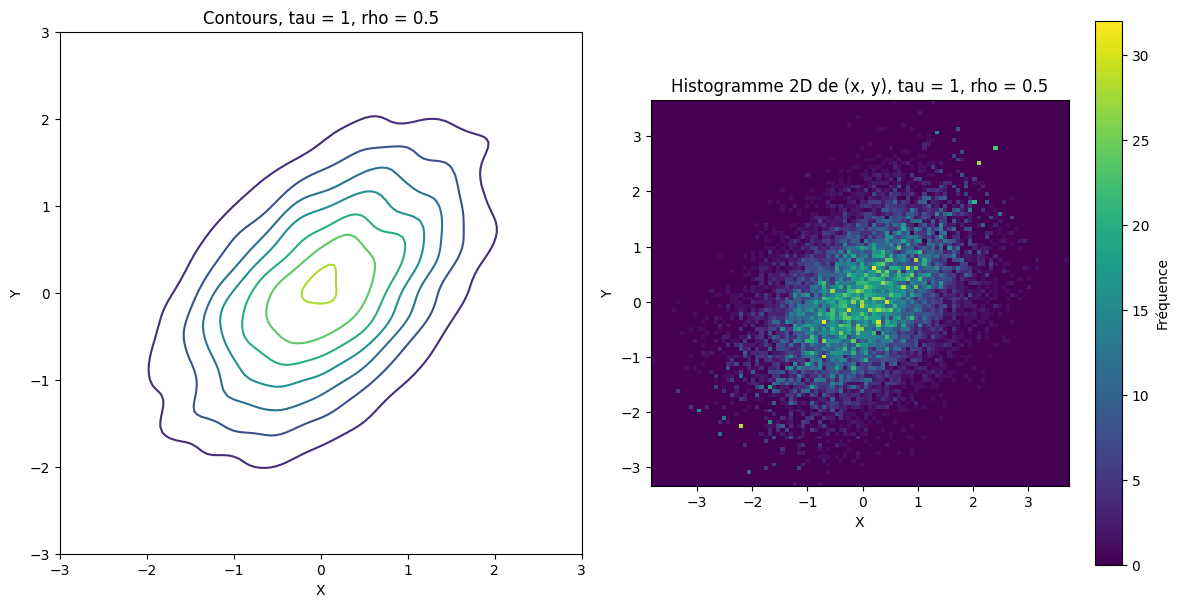

In [ ]:
contour_et_hist_plot(rw_mh[:,0], rw_mh[:,1], "tau = 1, rho = " + str(rho))

In [ ]:
rw_mh = rw_metropolis_hastings(2 * 10**(4), f, tau = 0.2)

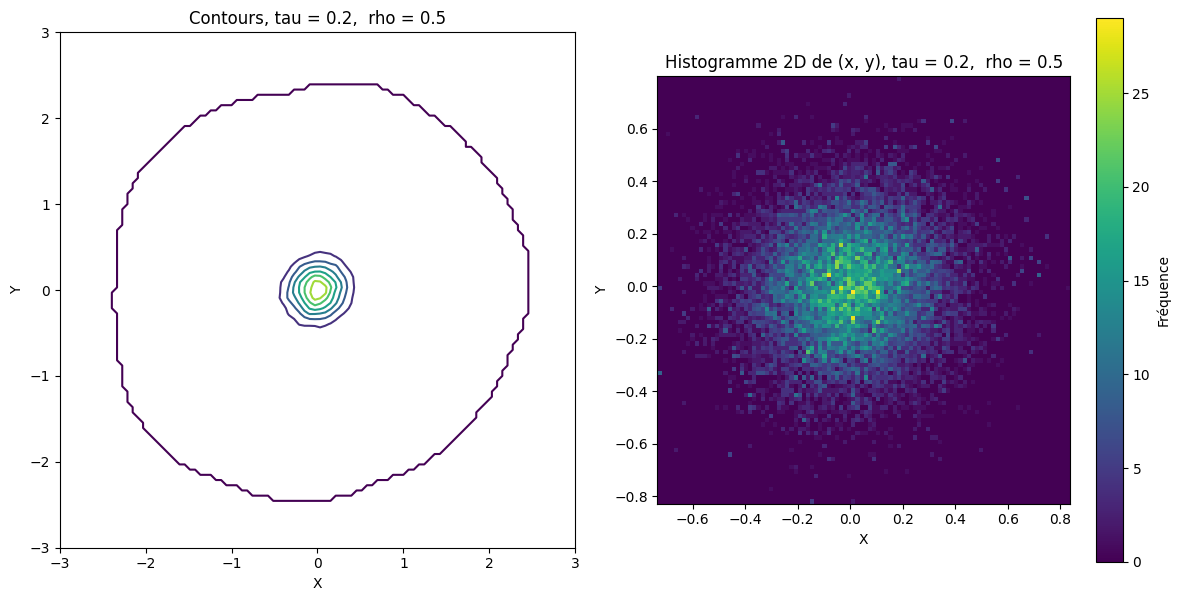

In [ ]:
contour_et_hist_plot(rw_mh[:,0], rw_mh[:,1], "tau = 0.2,  rho = " + str(rho))

In [ ]:
rw_mh = rw_metropolis_hastings(2 * 10**(4), f, tau = 2)

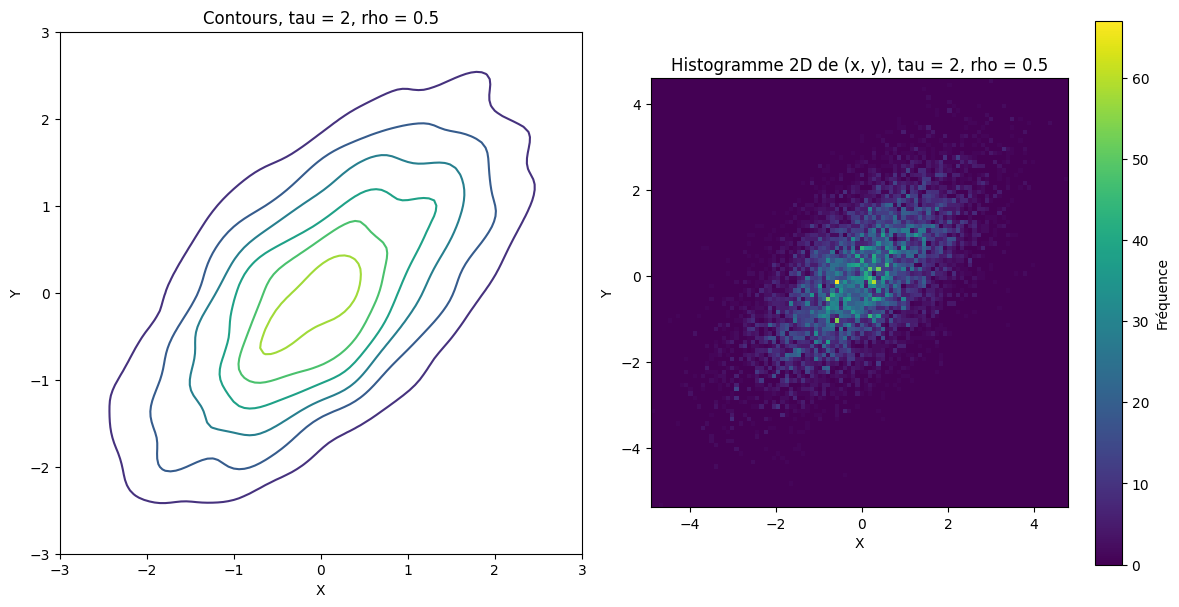

In [ ]:
contour_et_hist_plot(rw_mh[:,0], rw_mh[:,1], "tau = 2, rho = " + str(rho))
